# Relatório de EDA - Projeto Liga Portuguesa

Este notebook contém a Análise Exploratória de Dados (EDA) detalhada para o dataset `dataset_final_merged.csv`.
O objetivo é compreender a estrutura, validar decisões de imputação e analisar a viabilidade da modelação.

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuração visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Estatísticas Descritivas Gerais
Análise da estrutura inicial do dataset.

In [17]:
# Carregar Dataset
df = pd.read_csv('../Datasets/dataset_final_merged_v2.csv', low_memory=False)

print(f"Dimensões do Dataset: {df.shape[0]} jogos, {df.shape[1]} variáveis")
if 'Season' in df.columns:
    print(f"Janela Temporal: {df['Season'].min()} a {df['Season'].max()}")

# Exibir primeiras linhas
df.head()

Dimensões do Dataset: 4425 jogos, 310 variáveis
Janela Temporal: 2010-2011 a 2025-2026


,Div,Data,Equipa_Casa,Equipa_Visitante,Golos_Casa_Final,Golos_Visitante_Final,Resultado_Final,Golos_Casa_Intervalo,Golos_Visitante_Intervalo,Resultado_Intervalo,...,Away_hist_GolosEsperadosSemPenáltis,Away_hist_PassesProgressivos,Casa_Form_Pts5,Casa_Form_GM5,Casa_Form_GS5,Casa_Form_Empates5,Visitante_Form_Pts5,Visitante_Form_GM5,Visitante_Form_GS5,Visitante_Form_Empates5
0,P1,2010-08-13,Braga,Portimonense,3.0,1.0,H,2.0,0.0,H,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P1,2010-08-14,Marítimo,Vitória Setúbal,0.0,1.0,A,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P1,2010-08-14,Naval 1º de Maio,Porto,0.0,1.0,A,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P1,2010-08-14,Paços de Ferreira,Sporting CP,1.0,0.0,H,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P1,2010-08-15,Beira-Mar,União de Leiria,0.0,0.0,D,0.0,0.0,D,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dicionário de Dados (Amostra das Principais Variáveis)

| Variável | Descrição |
|----------|-----------|
| **Resultado_Final** | Resultado do jogo (H=Casa, D=Empate, A=Visitante) |
| **Home_hist_Pontos** | Média de pontos da equipa da casa na época anterior |
| **Home_xG** | Golos esperados (xG) da equipa da casa (se disponível) |
| **Odd_Casa_Bet365** | Odd da Bet365 para vitória da casa |
| **Posse_de_bola** | Percentagem de posse de bola (se disponível nos dados de jogo) |

## 2. Análise da Variável Alvo (Target)
Verificar o desbalanceamento das classes (Vitória Casa vs Empate vs Visitante).

C:\Users\diogo\AppData\Local\Temp\ipykernel_17876\1624717327.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Resultado_Final', data=df, order=['H', 'D', 'A'], palette='viridis')


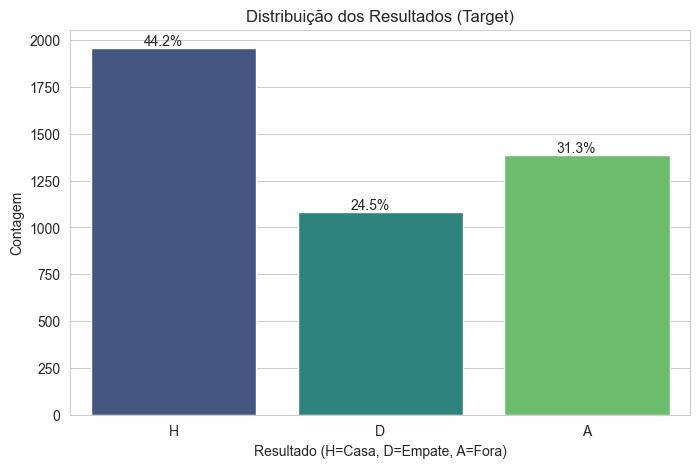

In [18]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Resultado_Final', data=df, order=['H', 'D', 'A'], palette='viridis')
plt.title('Distribuição dos Resultados (Target)')
plt.xlabel('Resultado (H=Casa, D=Empate, A=Fora)')
plt.ylabel('Contagem')

# Adicionar percentagens
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

## 3. Análise de Dados em Falta e Decisão "Recém-Promovidos"
Validação da imputação dos dados históricos para equipas que subiram de divisão.

**Decisão Técnica:** As equipas sem registo na época anterior (Recém-Promovidos) foram preenchidas com a **média das 3 piores equipas** dessa época anterior.
Para identificar estas imputações, procuramos valores decimais específicos em colunas que seriam, tipicamente, inteiras ou distintas (ex: Vitórias Históricas).

Total de Jogos com Equipa da Casa 'Recém-Promovida' (Dados Imputados): 290 (6.6%)


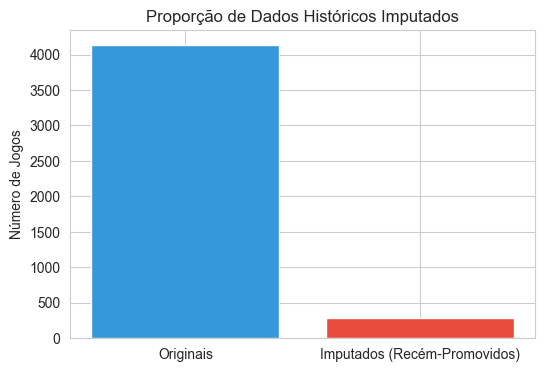

In [19]:
# Detetar linhas imputadas: Verificar se 'Home_hist_Vitórias' tem parte decimal significativa
# (Valores reais são inteiros, médias imputadas costumam ter dízimas)

if 'Home_hist_Vitórias' in df.columns:
    col_check = 'Home_hist_Vitórias'
    # Consideramos imputado se não for inteiro (resto da divisão por 1 diferente de 0)
    df['Imputed_Home'] = df[col_check] % 1 != 0

    num_imputed = df['Imputed_Home'].sum()
    num_total = len(df)
    perc_imputed = (num_imputed / num_total) * 100

    print(f"Total de Jogos com Equipa da Casa 'Recém-Promovida' (Dados Imputados): {num_imputed} ({perc_imputed:.1f}%)")

    # Visualizar a proporção
    plt.figure(figsize=(6, 4))
    plt.bar(['Originais', 'Imputados (Recém-Promovidos)'], [num_total - num_imputed, num_imputed], color=['#3498db', '#e74c3c'])
    plt.title('Proporção de Dados Históricos Imputados')
    plt.ylabel('Número de Jogos')
    plt.show()
else:
    print("Coluna 'Home_hist_Vitórias' não encontrada para verificação de imputação.")

## 4. Análise das Features (Variáveis Explicativas)
Correlações e impacto visual das variáveis no resultado.

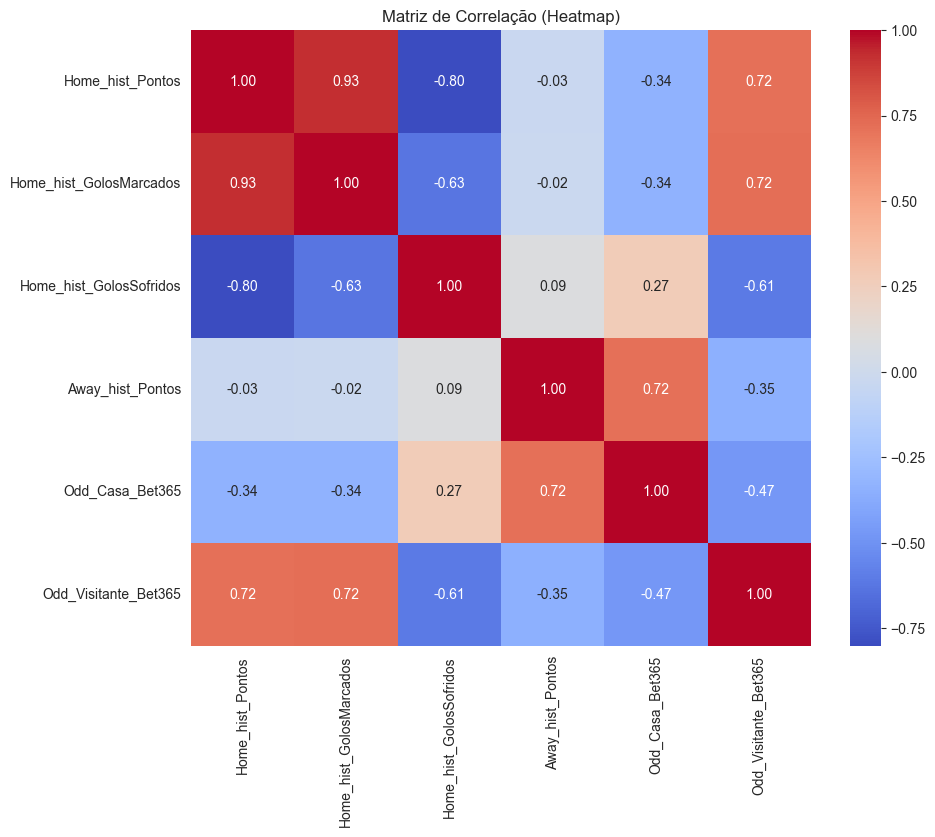

In [20]:
# Matriz de Correlação para variáveis chave
key_vars = ['Home_hist_Pontos', 'Home_hist_GolosMarcados', 'Home_hist_GolosSofridos', 
            'Away_hist_Pontos', 'Odd_Casa_Bet365', 'Odd_Visitante_Bet365']

# Filtrar apenas colunas existentes
vars_present = [c for c in key_vars if c in df.columns]

plt.figure(figsize=(10, 8))
sns.heatmap(df[vars_present].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação (Heatmap)')
plt.show()

C:\Users\diogo\AppData\Local\Temp\ipykernel_17876\1351109561.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado_Final', y='Home_hist_Pontos', data=df, order=['H', 'D', 'A'], palette='Set2')


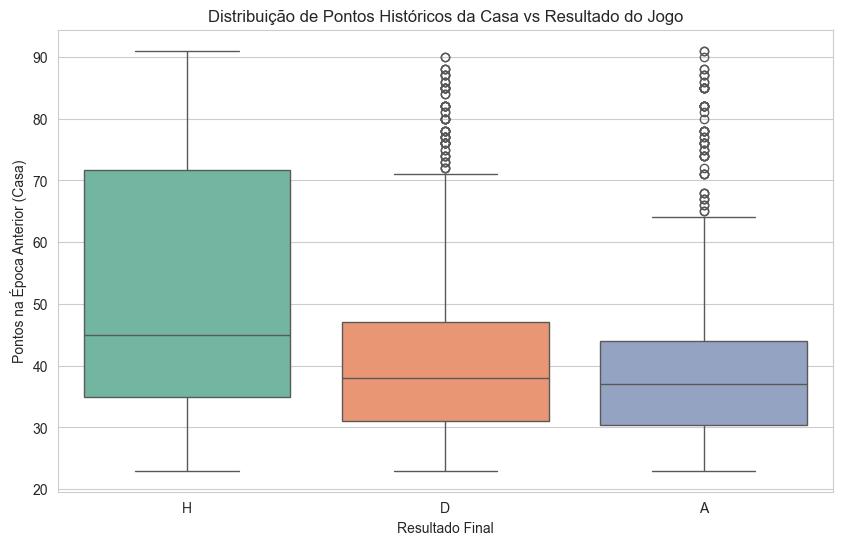

In [21]:
# Boxplots: Histórico de Pontos vs Resultado Final
if 'Home_hist_Pontos' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Resultado_Final', y='Home_hist_Pontos', data=df, order=['H', 'D', 'A'], palette='Set2')
    plt.title('Distribuição de Pontos Históricos da Casa vs Resultado do Jogo')
    plt.xlabel('Resultado Final')
    plt.ylabel('Pontos na Época Anterior (Casa)')
    plt.show()

## 5. Comparação Pré e Pós Processamento (Scaling)
Simulação do efeito do StandardScaler numa variável.
Como o dataset original contém valores reais (pontos, golos), a modelação (especialmente Regressão Logística) beneficia do Scaling.

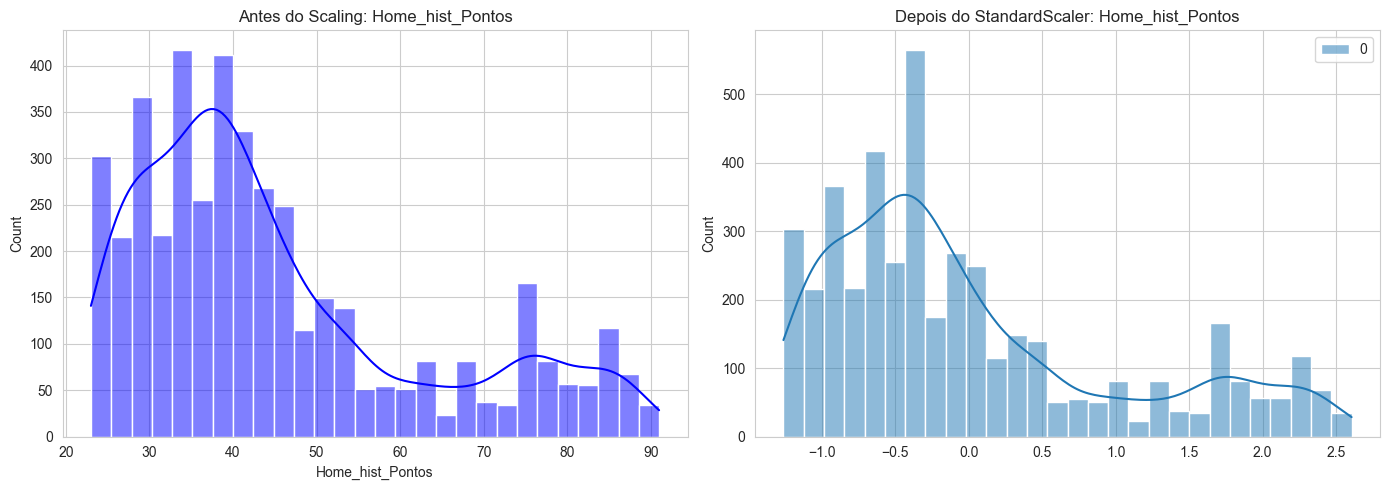

In [22]:
from sklearn.preprocessing import StandardScaler

feature_to_scale = 'Home_hist_Pontos'

if feature_to_scale in df.columns:
    # Dados Originais
    original_data = df[feature_to_scale].dropna()

    # Dados Scaled
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(original_data.values.reshape(-1, 1))

    # Plot Comparativo
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(original_data, kde=True, ax=ax[0], color='blue')
    ax[0].set_title(f'Antes do Scaling: {feature_to_scale}')

    sns.histplot(scaled_data, kde=True, ax=ax[1], color='green')
    ax[1].set_title(f'Depois do StandardScaler: {feature_to_scale}')

    plt.tight_layout()
    plt.show()

## 6. Análise de Novas Features: Forma Recente (5 Jogos)
Análise das novas variáveis de "Forma" (`Form_Pts5`, `Form_GM5`, etc.) que representam o desempenho nos últimos 5 jogos, introduzidas na versão v2 do dataset.

C:\Users\diogo\AppData\Local\Temp\ipykernel_17876\466250385.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado_Final', y='Casa_Form_Pts5', data=df, order=['H', 'D', 'A'], palette='viridis')


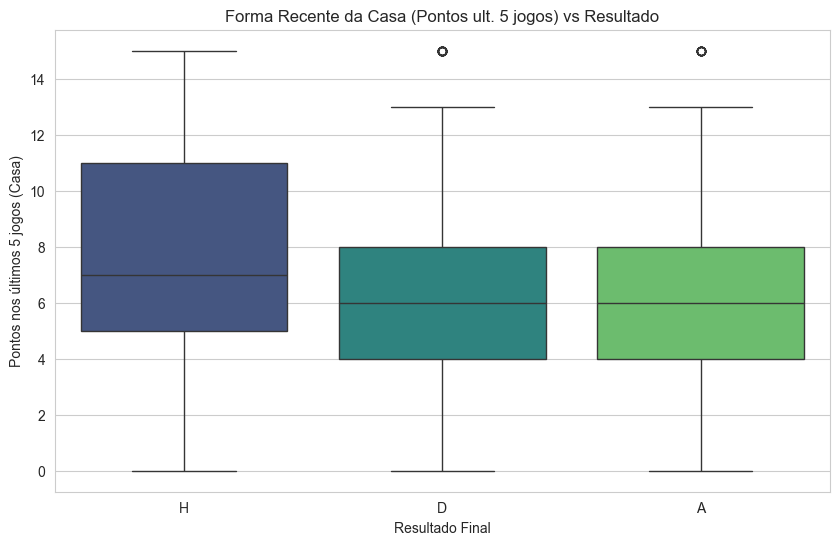

C:\Users\diogo\AppData\Local\Temp\ipykernel_17876\466250385.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado_Final', y='Visitante_Form_Pts5', data=df, order=['H', 'D', 'A'], palette='viridis')


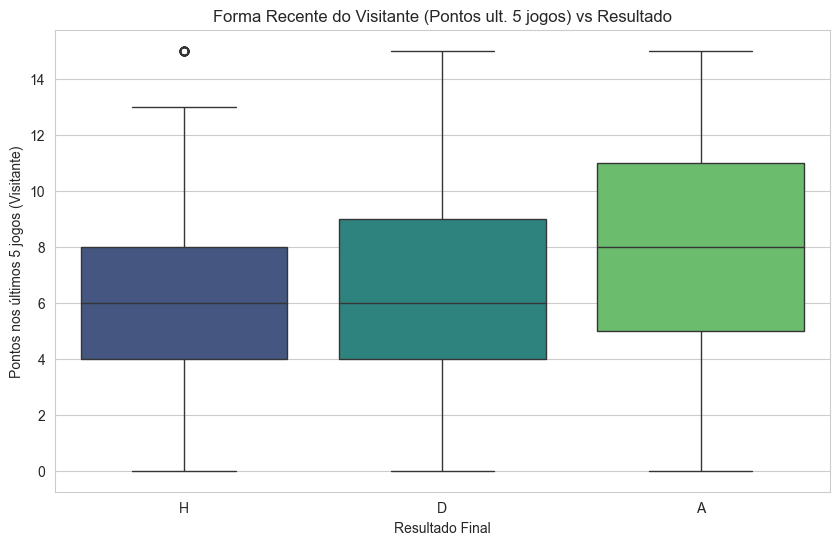

In [23]:
# Boxplot: Forma da Casa (Pontos 5 jogos) vs Resultado
if 'Casa_Form_Pts5' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Resultado_Final', y='Casa_Form_Pts5', data=df, order=['H', 'D', 'A'], palette='viridis')
    plt.title('Forma Recente da Casa (Pontos ult. 5 jogos) vs Resultado')
    plt.xlabel('Resultado Final')
    plt.ylabel('Pontos nos últimos 5 jogos (Casa)')
    plt.show()

# Boxplot: Forma do Visitante (Pontos 5 jogos) vs Resultado
if 'Visitante_Form_Pts5' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Resultado_Final', y='Visitante_Form_Pts5', data=df, order=['H', 'D', 'A'], palette='viridis')
    plt.title('Forma Recente do Visitante (Pontos ult. 5 jogos) vs Resultado')
    plt.xlabel('Resultado Final')
    plt.ylabel('Pontos nos últimos 5 jogos (Visitante)')
    plt.show()

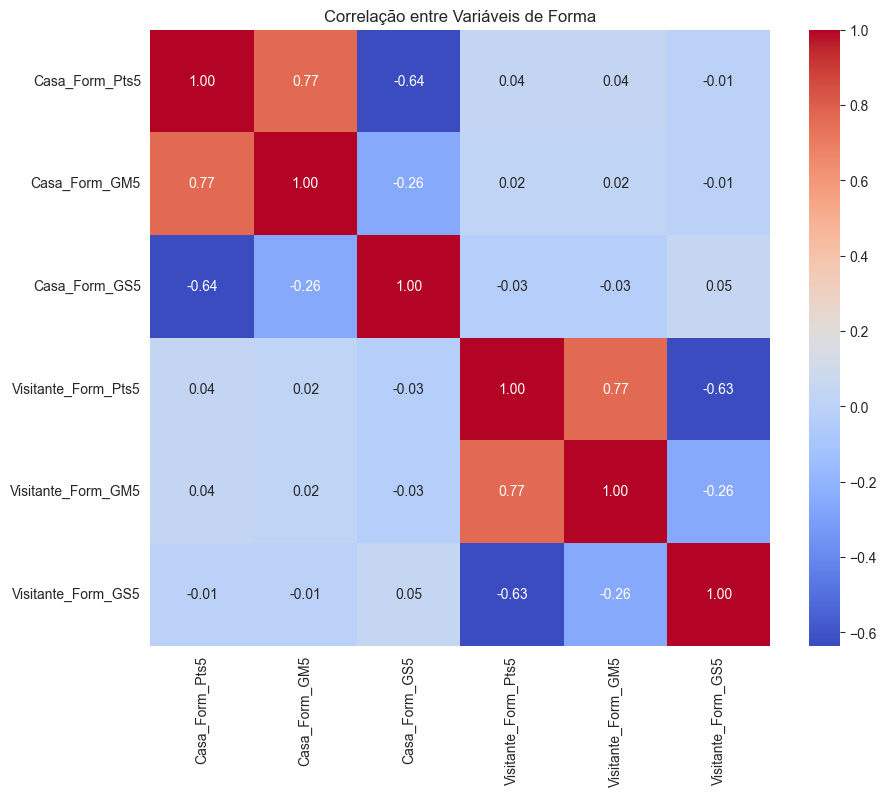

In [24]:
# Matriz de Correlação das Variáveis de Forma
form_vars = ['Casa_Form_Pts5', 'Casa_Form_GM5', 'Casa_Form_GS5',
             'Visitante_Form_Pts5', 'Visitante_Form_GM5', 'Visitante_Form_GS5']

vars_present = [c for c in form_vars if c in df.columns]

if vars_present:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[vars_present].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlação entre Variáveis de Forma')
    plt.show()

## 3. Análise de Features Avançadas (xG, Posse, etc.)
Novas métricas introduzidas para melhorar a performance do modelo.

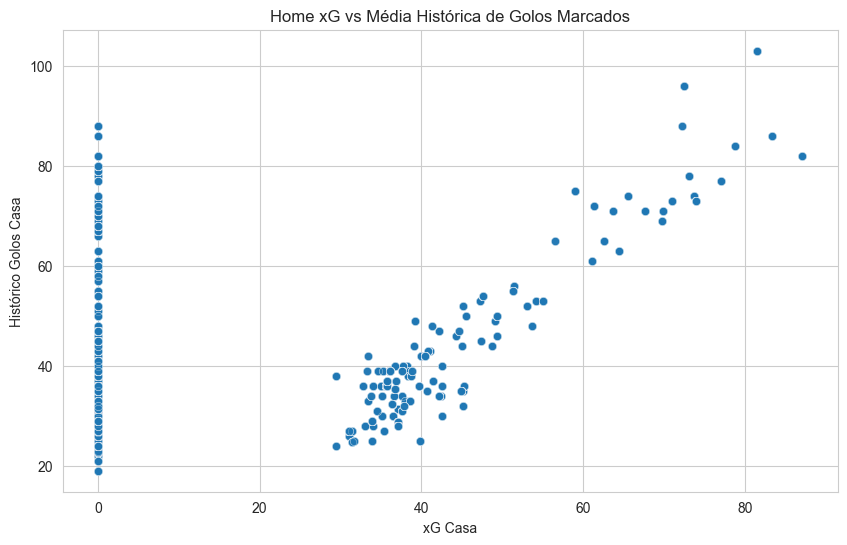

In [25]:
# xG (Golos Esperados) vs Golos Reais
if 'Home_hist_GolosEsperados' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Home_hist_GolosEsperados', y='Home_hist_GolosMarcados', data=df, alpha=0.5)
    plt.title('Home xG vs Média Histórica de Golos Marcados')
    plt.xlabel('xG Casa')
    plt.ylabel('Histórico Golos Casa')
    plt.show()

C:\Users\diogo\AppData\Local\Temp\ipykernel_17876\3631587793.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado_Final', y='Home_hist_PosseDeBola', data=df, order=['H', 'D', 'A'], palette='viridis')


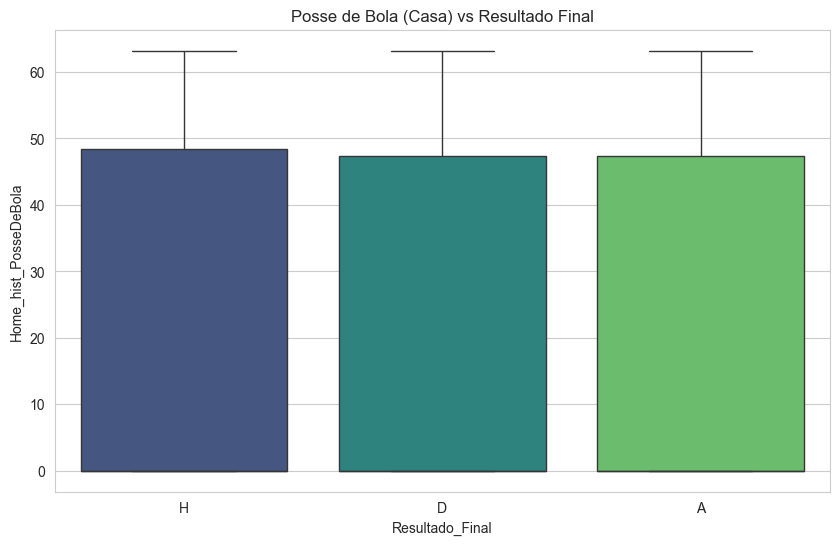

In [26]:
# Posse de Bola vs Resultado
if 'Home_hist_PosseDeBola' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Resultado_Final', y='Home_hist_PosseDeBola', data=df, order=['H', 'D', 'A'], palette='viridis')
    plt.title('Posse de Bola (Casa) vs Resultado Final')
    plt.show()

C:\Users\diogo\AppData\Local\Temp\ipykernel_17876\1528090574.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resultado_Final', y='Home_hist_PassesProgressivos', data=df, order=['H', 'D', 'A'], palette='viridis')


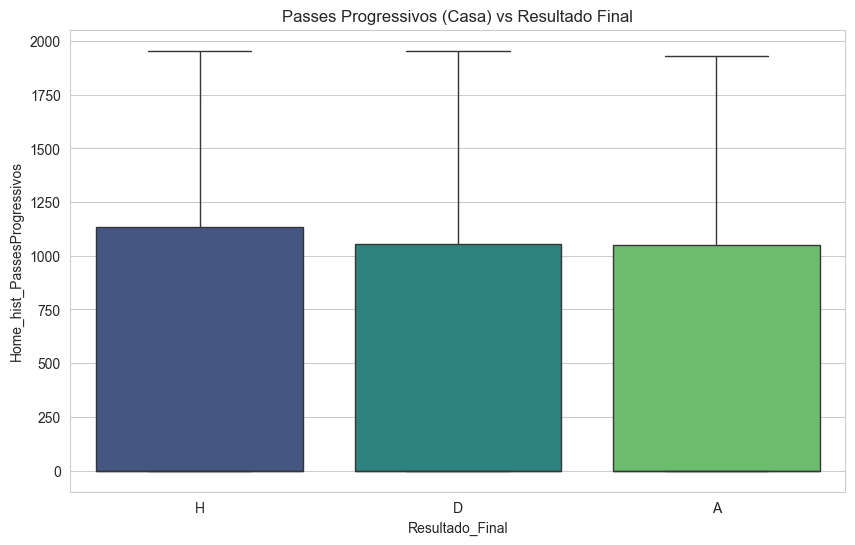

In [27]:
# Passes Progressivos vs Resultado
if 'Home_hist_PassesProgressivos' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Resultado_Final', y='Home_hist_PassesProgressivos', data=df, order=['H', 'D', 'A'], palette='viridis')
    plt.title('Passes Progressivos (Casa) vs Resultado Final')
    plt.show()

## 4. Análise de Empates (A "Maldição")
Investigação específica sobre a ocorrência de empates.

<Figure size 1000x600 with 0 Axes>

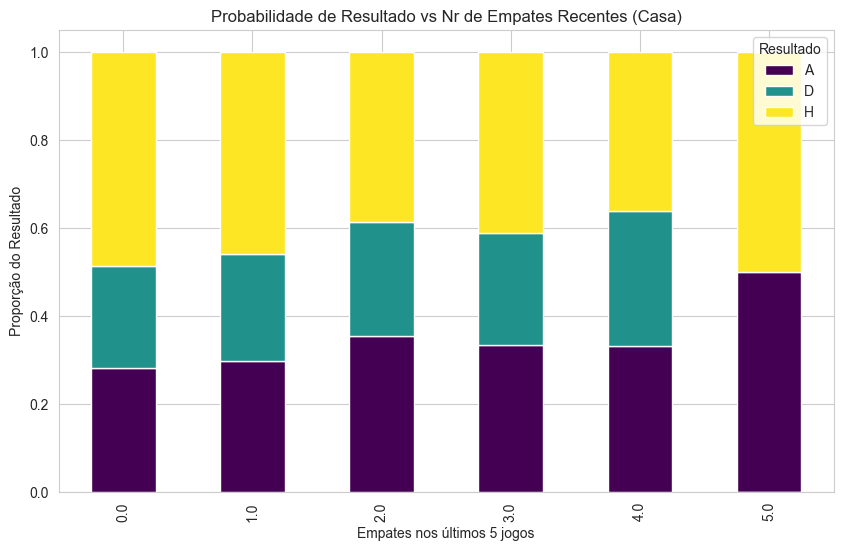

In [28]:
# Impacto da "Forma de Empates" (Quantos empates nos últimos 5 jogos?)
if 'Casa_Form_Empates5' in df.columns:
    plt.figure(figsize=(10, 6))
    # Agrupar por nr de empates recentes e ver a % de resultados
    props = df.groupby('Casa_Form_Empates5')['Resultado_Final'].value_counts(normalize=True).unstack()
    props.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Probabilidade de Resultado vs Nr de Empates Recentes (Casa)')
    plt.xlabel('Empates nos últimos 5 jogos')
    plt.ylabel('Proporção do Resultado')
    plt.legend(title='Resultado')
    plt.show()